# CALCULO CALOR NETO 

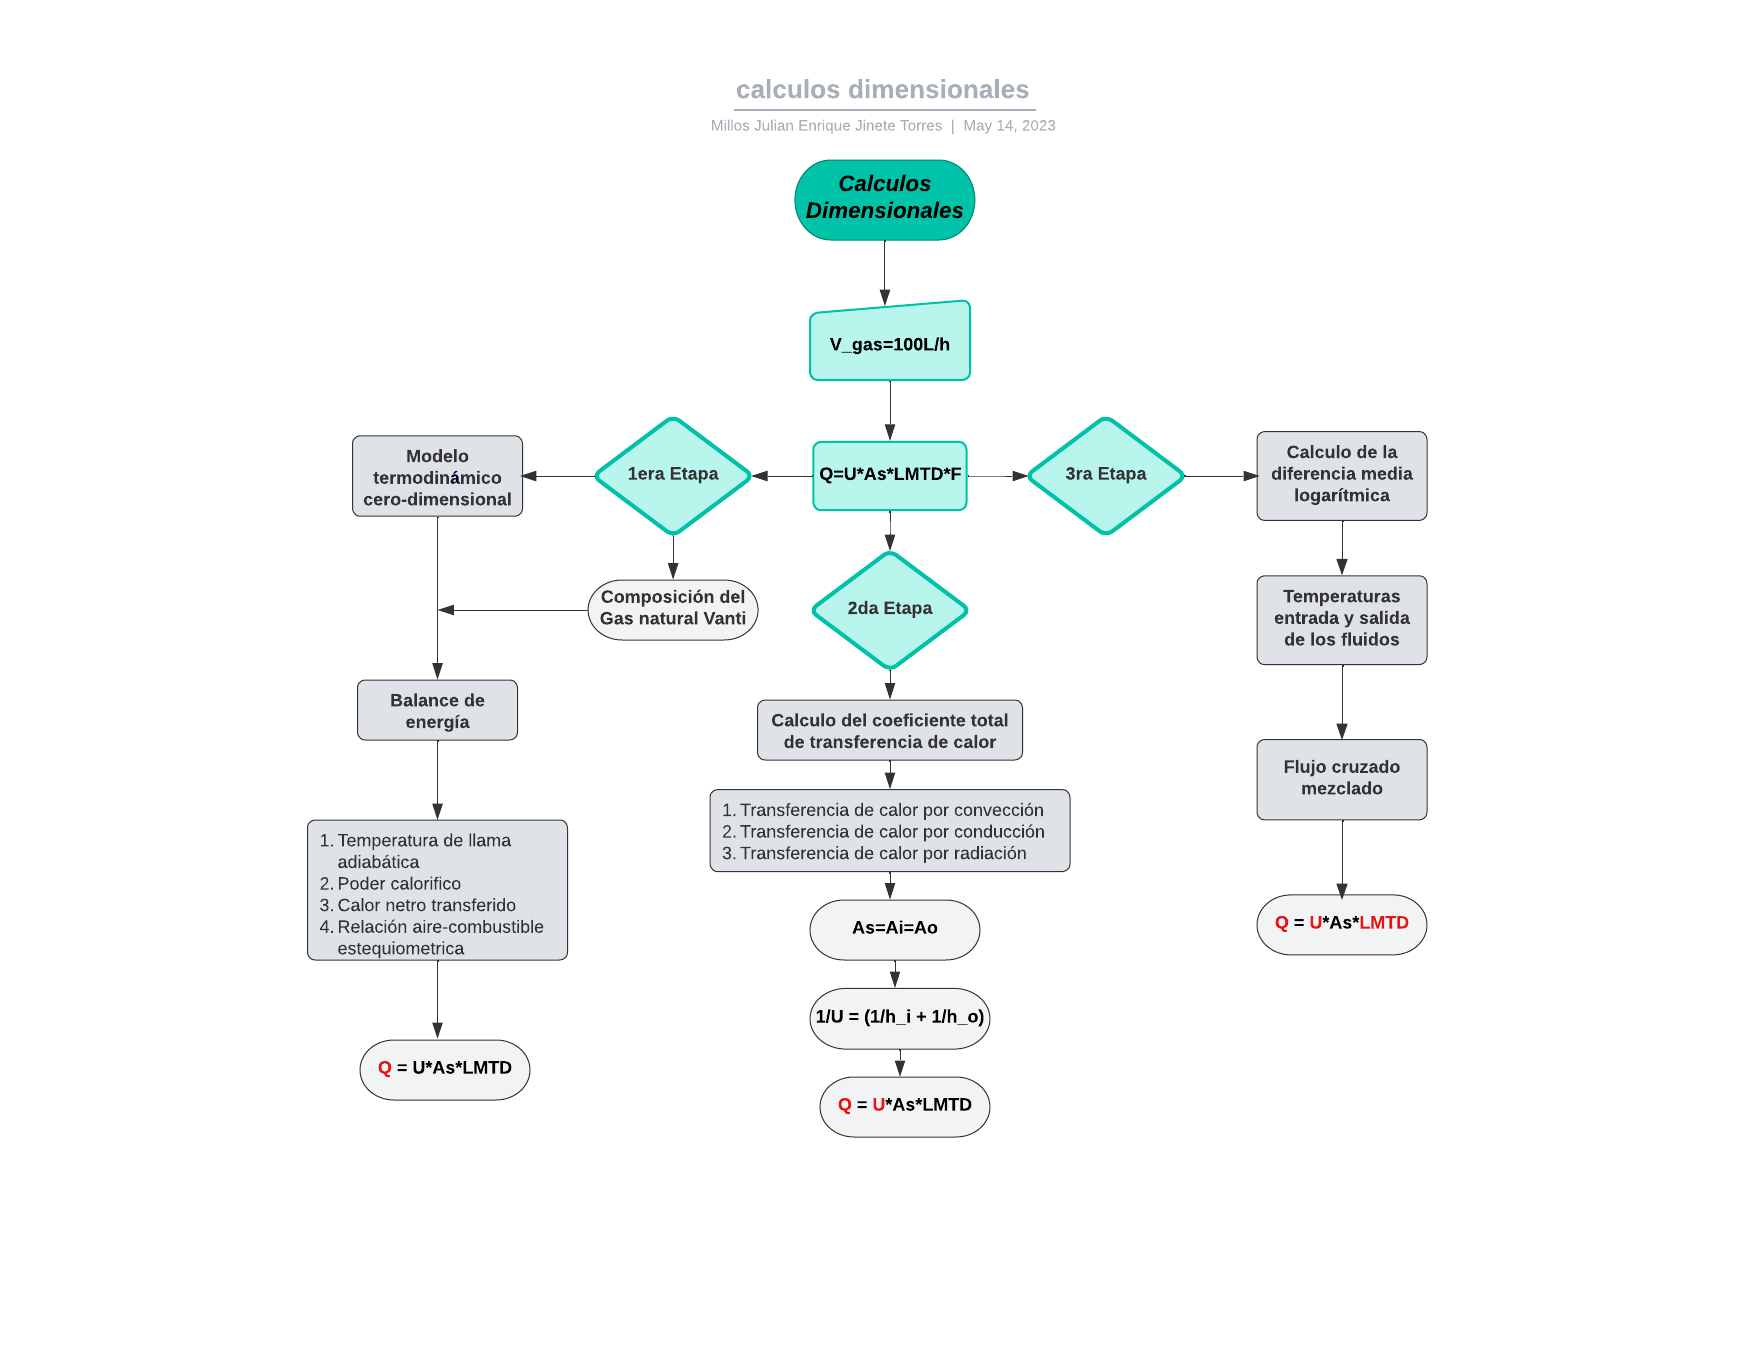

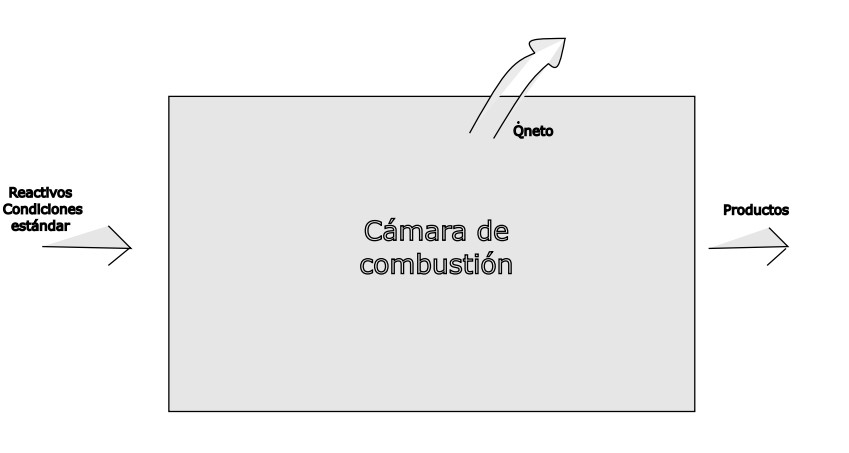

In [76]:
#Libraries
%matplotlib inline
import matplotlib.pyplot as mp
import CoolProp.CoolProp as CP
import numpy as np
import math as mt

#Initial conditions for design
flow_gn = 100 #[L/h] #volumetric flow initial condition
R_u = 0.08205 #[atm*L/mol*K] gas universal constant
d_i = 0.0762 #[m] inner diameter shell
d_o = 0.1524 #[m] outer diameter shell
d_w = 0.0127 #[m] water's diameter spiral tube
d_e = (d_i+d_o)/2
P_atm_bga = 90888.525 # [Pa] según vanti
P_atm = 1 #atm , 101325 Pa
T_ad = 2300 #[K]
Tw_sup = 50+273.15 #[K] temperatura de superficie
Tg_out = 27+273.15 #[K]
T_rocio = 55.8 #[C] temperatura de rocío en bga Pi(H2O)=0.163 atm (valor tomado de tabla A-5 termod.cengel)
stfb = 5.670e-8 #cte stefan boltzman
Re_crit = 2300 # número de reynolds critico

#DICTIONARIES*****************************************************
#natural gas composition from vanti mol/mol
gn ={#fracciones molares reactivos
    "CH4":0.8186,
    "C2H6":0.1161,
    "C3H8":0.0192,
    "C4H10":4.5*10**-3,
    "N2":9*10**-3,
    "CO2":0.0318
}

#molar mass of each component of natural gas Kg/mol
mM =  { "CH4":CP.PropsSI('M', 'CH4'),
    "C2H6":CP.PropsSI('M', 'ethane'),
    "C3H8":CP.PropsSI('M', 'C3H8'),
    "C4H10":CP.PropsSI('M', 'Butane'),
    "N2":CP.PropsSI('M', 'N2'),
    "CO2":CP.PropsSI('M', 'CO2')
}
 
#products natural gas composition
gn_p = { #fracciones molares de los productos humedos del gas natural en condiciones estequiometricas
    "CO2":0.1015,
    "N2":0.7156,
    "H2O":0.1827
}

#natural gas products without water
gn_pw ={#fracciones molares de los productos secos del gas natural en condiciones estequiometricas
    "CO2":0.1242,
    "N2":0.8757,
}

#prandtl numbers of natural gas products
pprandtl = { #numeros de prandtl a 2300K y 1 atm , tomados de Transf.deCalor cengel
    "CO2":0.8815,
    "N2":0.4483,
    "H2O":0.7833
}

#prandtl numbers of natural gas products
ppprandtl = { #numeros de prandtl a 1000C y 1 atm , tomados de Transf.deCalor cengel
    "CO2":0.7455,
    "N2":0.7022,
    "H2O":0.8639
}

#thermal conductivity of natural gas products
cconductivity = { #conductividad térmica a 2300K y 1 atm , tomados de Transf.deCalor cengel
    "CO2":0.1152,
    "N2":0.1859,
    "H2O":0.2918
}

#Molar mass of each product of natural gas Kg/mol
mM_p = {
    "CO2":CP.PropsSI('M', 'CO2'),
    "N2":CP.PropsSI('M', 'N2'),
    "H2O":CP.PropsSI('M', 'H2O')
}

#Formation enthalpy(25C,1atm)[kJ/kmol] tomado de turns
hf = {
    "CH4":-74873,
    "C2H6":-84670,
    "C3H8":-103800,
    "C4H10":-127100,
    "N2":0,
    "CO2":-393522,
    "H2O":-285830
}

#FUNCTIONS**************************************************************
#function for browsing the dictionaries
def browse(dictionary):
    #print(dictionary)
    value = ''
    for i in dictionary:
        value += i +" " + ":" + " " + str(dictionary[i]) + "\n" 
    print(value)

#function for showing the heat exchanger dimensions        
def showSize():
    print(f"\t Área del Intercambiador:{A:.3f}[m^2]\n \t Longitud Intercambiador(Sección anular):{L_inter:.3f}[m]\n \
    \t Longitud tubería agua: {L_tubo:.3f}[m]\n \t Número de espiras: {cont+1}")
    
#function for calculating the dinamic viscosity of natural gas products
def dinaViscosity(T,P,fgn_p):#(temp,presión,fracciones molares productos)
    miuSum = 0 #acumulador
    if T<(T_rocio+273.15):#temperatura de rocío vapor de agua condiciones estándar
        miu_p = {
        "CO2":CP.PropsSI('V', 'T', T, 'P', P, "CO2"),
        "N2":CP.PropsSI('V', 'T', T, 'P', P, "N2")
    }
        miuSum = ((gn_pw["CO2"]*miu_p["CO2"])+(gn_pw["N2"]*miu_p["N2"]))
            
    else:
        miu_p = {
        "CO2":CP.PropsSI('V', 'T', T, 'P', P, "CO2"),
        "N2":CP.PropsSI('V', 'T', T, 'P', P, "N2"),
        "H2O":CP.PropsSI('V', 'T', T, 'P', P, "H2O")
    }
        for i in (miu_p):
            miuSum += miu_p[i]*fgn_p[i]
    return miuSum #devuelve la viscocidad dinámica de los productos[Kg/m*s]

#for calculating the prandtl number of the natural gas products 
def prandtl(T,P,fgn_pw,fprandtl,fgn_p): #(Kelvin,pascal,dic_GNproductos sin agua,dic_#prandtl,dic_fracc.mol.prod)
    Pr = 0
    if T<T_rocio+273.15: #si está por debajo de la temperatura de rocío no tiene en cuenta el agua
        for i in fgn_pw:
            Cp = CP.PropsSI('CPMASS', 'T', T, 'P', P, i)
            mu = CP.PropsSI('VISCOSITY', 'T', T, 'P', P, i)
            k = CP.PropsSI('CONDUCTIVITY', 'T', T, 'P', P, i)
            Pr += ((Cp * mu) / k)*fgn_pw[i]
    else:
        for i in fgn_p:
            Pr += fprandtl[i]*fgn_p[i]
    return Pr

#for calculating the thermal conductivity of natural gas products
def conductivity (T,P,fgn_pw,fconductivity,fgn_p):#(Kelvin,pascal,dic_GNproductos sin agua,dic_condc.térm.prod,dic_fracc.mol.prod)
    kc = 0
    if T<T_rocio+273.15: #si está por debajo de la temperatura de rocío no tiene en cuenta el agua
        for i in fgn_pw:
            k = CP.PropsSI('CONDUCTIVITY', 'T', T, 'P', P, i)
            kc += k*fgn_pw[i]
    else:
        for i in fgn_p:
            kc += fconductivity[i]*fgn_p[i]
    return kc

#Function for caculating the water properties
def wProperties(T,P,fluid): #(Celsius, Pascal) calcula las propiedades de cualquier fluido
    rho = CP.PropsSI('D', 'T', T+273.15, 'P', P, fluid) #[Kg/m^3]
    mu = CP.PropsSI('V', 'T', T+273.15, 'P', P, fluid) #[Kg/m*s]
    Cp = CP.PropsSI('CPMASS', 'T', T+273.15, 'P', P, fluid)/1000 #[Kj/Kg*K]
    k = CP.PropsSI('CONDUCTIVITY', 'T', T+273.15, 'P', P, fluid) #[W/m*K]
    Pr = ((Cp * mu) / k)*1000
    return rho,mu,Cp,k,Pr

#function for calculating the natural gas density [reactivos]
def density(T,P,fgn,fmM): #(T[C],P[atm],fgn[gas natural composition],fnM[molar mass])
    v = (R_u*(T+273.15))/P #[L/mol]
    vSum = 0
    for i in gn:
        vSum += ((fgn[i]*v)/fmM[i])/1000 #[m^3/Kg]
    return 1/vSum #devuelve la densidad del gas [kg/m^3] 

#function for calculating the products natural gas density
def pdensity(T,P,fgn_p,fmM_p):#(temp,presión,fracciones molares productos, masa molar productos)
    v = (R_u*(T+273.15))/P #[L/mol]
    vSum = 0
    if T<55.8: #temperatura de rocío vapor de agua condiciones estándar
        vSum =((gn_pw["CO2"]*(v/fmM_p["CO2"]))+(gn_pw["N2"]*(v/fmM_p["N2"])))/1000 #[m^3/Kg]
    else:
        for i in gn_p:
            vSum += ((fgn_p[i]*v)/fmM_p[i])/1000 #[m^3/Kg]
    return 1/vSum #devuelve la densidad del gas [kg/m^3]

#Function for calculating the experimental HHV and the error rate
def fHHV(VH2O,VGas,T1,T2): #(lpm,lpm,Celsius,Celsius,Pascal)
    T_prom = (T1+T2)/2
    Cp_prom = CP.PropsSI('CPMASS', 'T', T_prom+273.15, 'P', 90888.525 , 'H2O')/1000 #[Kj/Kg*K]
    rhow_prom = CP.PropsSI('D', 'T', T_prom+273.15, 'P', 90888.525 , 'H2O') #[Kg/m^3]
    rho_gas = density(25,0.897,gn,mM) #Tamb,PatmBGA,componentesGN,MasaMolarGN
    delta_T = T2-T1
    pcs = (Cp_prom*rhow_prom*VH2O*delta_T)/(rho_gas*VGas)
    error = abs(((pcs - HHV)/HHV)*100)
    return pcs,error #kJ/Kg
#FUNCTIONS**************************************************************

#Stequiometric balance for natural gas
# {0.8186(CH4) + 0.1161(C2H6) + 0.0192(C3H8) + 4,5x10^-3(C4H1O) + 9x10^-3(N2) +
# 0.0318(CO2)}fuel + {α(O2+3.76N2)}air -> V_CO2(CO2)+V_H20(H20)+V_N2(N2)

vCO2 = gn["CH4"]+2*gn["C2H6"]+3*gn["C3H8"]+4*gn["C4H10"]+gn["CO2"]
vH2O = (4*gn["CH4"]+6*gn["C2H6"]+8*gn["C3H8"]+10*gn["C4H10"])/2
alpha = (2*vCO2+vH2O-2*gn["CO2"])/2
vN2 = (2*gn["N2"]+alpha*3.76*2)/2

print("**************COEFICIENTES MOLARES PRODUCTOS**************")
print(f"V_CO2: {vCO2:.4f}\t V_H2O: {vH2O}\t α: {alpha}\t V_N2: {vN2:.4f}")

mM_gn = 0 #declaro la variable acumuladora como cero(masa molar del gas natural)
for i in gn or mM: #for para recorrer el diccionario
    mM_gn += gn[i]*mM[i]#Kg/mol #sumatoria de la multiplicación de la cantidad de moles por la masa molar de cada elemento

#calculation of the stoichiometric air-fuel ratio
air_fuel = (4.76*alpha*CP.PropsSI('M','AIR'))/mM_gn #Kg(air)/Kg(fuel)

#calculation of net molar heat [Kj/Kmol] 
q_neto_m = (vCO2*hf["CO2"]+vH2O*hf["H2O"])-(gn["CH4"]*hf["CH4"]+gn["C2H6"]*hf["C2H6"]+gn["C3H8"]*hf["C3H8"]+gn["C4H10"]*hf["C4H10"]+gn["CO2"]*hf["CO2"])
q_neto = q_neto_m/(mM_gn*1000) #[Kj/Kg] net heat = HHV

#the net heat is equal to higher heat value qneto=PCS
HHV = abs(q_neto)
print(f"\n \t HHV teórico : {HHV:.3f}[Kj/Kg]")
print(f"\n \t ρ reactivos GN (27°C,1atm) : {density(27,1,gn,mM):.3f}[Kg/m^3]")

m_dot_fuel = density(27,1,gn,mM)*(flow_gn/1000) #[Kg/h] masic flow of natural gas
print(f"\n \t m ̇_fuel: {m_dot_fuel:.3f}[Kg/h]")


Q_neto = (q_neto*m_dot_fuel)/3600 #net heat [Kw]
print(f"\n \t Qneto: {Q_neto:.3f}[Kw]")

#masic flow of air
m_dot_air = air_fuel*m_dot_fuel #[Kg(air)/h]
m_dot_total = m_dot_air+m_dot_fuel #[Kg/h]total mass flow of reagents m_react=m_prod


**************COEFICIENTES MOLARES PRODUCTOS**************
V_CO2: 1.1582	 V_H2O: 2.0848	 α: 2.1688	 V_N2: 8.1637

 	 HHV teórico : 49809.214[Kj/Kg]

 	 ρ reactivos GN (27°C,1atm) : 0.719[Kg/m^3]

 	 m ̇_fuel: 0.072[Kg/h]

 	 Qneto: -0.995[Kw]


# CALCULO COEFICIENTE TOTAL DE TRASNFERENCIA DE CALOR

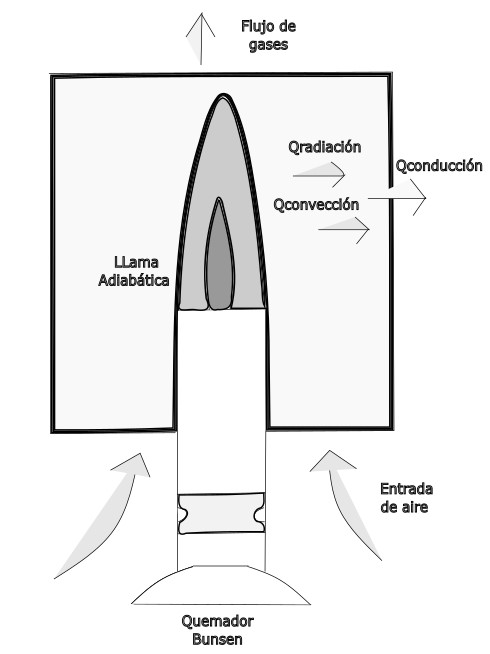

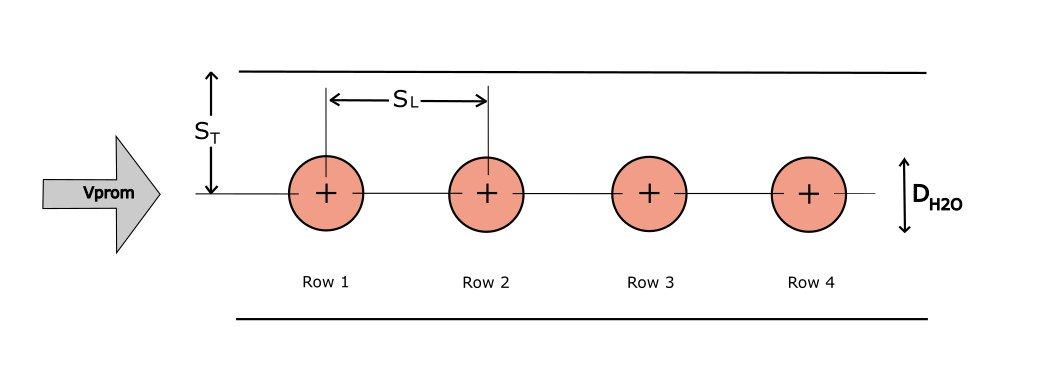

In [77]:
#h_o coef.transferencia de calor convección exterior (GAS)
A_c = ((mt.pi*(d_o**2-d_i**2))/4)-(d_w*(mt.pi*(d_o+d_i)/2)) #[m^2] anular section area
A_c_sa = ((mt.pi*(d_o**2-d_i**2))/4) #0.01368 #área transversal de la sección anular 

d_mix_prom = (pdensity(2026.85,1,gn_p,mM_p)+pdensity(27,1,gn_p,mM_p))/2 #[Kg/m^3] #densidad promedio (d(Tad)+d(Tg_out))/2

#average gas velocity
ST = (d_e-d_i) #distancia entre el centro de la sección transversal de la espira hasta la pared del intercambiador
v_gas = m_dot_total/(d_mix_prom*A_c_sa) #[m/h]
v_max = (ST/(ST-(d_w/2)))*v_gas #velocidad máxima del gas [m/h]
print(f"\n \t Velocidad promedio gas: {v_gas:.3f}[m/h]")

perimetro = 2*mt.pi*(d_i+d_o) #[m]perimetro de la sección anular
d_h = 4*A_c/perimetro #[m] diametro hidraulico
L_c = d_h #[m] Longitud caracteristica

#calculo el promedio de la viscodidad dinámica a temperatura de llama ad y temperatura de salida de los gases
miu_mix_prom = (dinaViscosity(2300,101325,gn_p)+dinaViscosity(300,101325,gn_p))/2 #[Kg/m*s]

Re_gas = (d_mix_prom*v_max*L_c)/(miu_mix_prom*3600)  #número de reynolds
print(f"\n \t #Reynolds: {Re_gas:.3f}")

#calculo número de prandtl promedio a temperatura de llama ad y temperatura de salida de los gases
prandtl_mix_prom = (prandtl(300,101325,gn_pw,pprandtl,gn_p)+prandtl(2300,101325,gn_pw,pprandtl,gn_p))/2

#calculo número de prandtl a temperatura de superficie del intercambiador
prandtl_mix_s =prandtl(1300,101325,gn_pw,ppprandtl,gn_p) 

#calculo conductividad térmica promedio a temperatura de llama ad y temperatura de salida de los gases
k_mix_prom = (conductivity(300,101325,gn_pw,cconductivity,gn_p)+conductivity(2300,101325,gn_pw,cconductivity,gn_p))/2 #[W/m*K]

#calculo número de nusselt según Zukauskas
C_1 = 0.8  #"página 470 incropera tabla 7.5"
mg = 0.4 #"página 470 incropera tabla 7.5"
Nu = C_1*Re_gas**mg*(prandtl_mix_prom**0.36)*(prandtl_mix_prom/prandtl_mix_s)**(1/4)
 

#calculo coeficiente de transferencia convectivo para el gas
h_gas = (Nu*k_mix_prom)/L_c
print(f"\n \t coeficiente convectivo gas h_o: {h_gas:.3f}[W/m^2*K]")

#Calculo del coeficiente de radiación h_radiación (GAS)
Pw = P_atm*gn_p["H2O"] #presión parcial agua
Pc = P_atm*gn_p["CO2"] #presión parcial dioxido de carbono
L = 0.65*(d_i*3.28084) #3.6V/As
e_c = 0.025 #gráfica 13-36 @1500K Pc*L=0.025
e_w = 0.016 #gráfica 13-36 @1500K Pw*L=0.045
C_c = 1.1 #gráfica 13-37 Pc*L=0.025
C_w = 1.1 #gráfica 13-37 (Pw+P)/2=0.045
delta_e = 0 #Pc*L+Pw*L=0,07  Pw/(Pc+Pw)=0,643
e_gas = C_c*e_c + C_w*e_w - delta_e
T_sup = 1000 #[K]
T_gas = 1500 #[K]
h_rad = e_gas*stfb*(T_sup**2+T_gas**2)*(T_sup+T_gas) #[W/m^2*K]
h_comb = h_rad + h_gas #[W/m^2*K]
print(f"\n \t coeficiente radiación gas h_rad: {h_rad:.3f}[W/m^2*K]")
print(f"\n \t coeficiente combinado gas h_comb: {h_comb:.3f}[W/m^2*K]")


#CALCULO DEL h_i COEFICIENTE DE CONVECCIÓN INTERNA (AGUA)
Tw_in = 25 #[C]
Tw_out = 30 #[C]
Tw_prom = (Tw_in+Tw_out)/2 #[C]
delta_w = Tw_out-Tw_in #[C]

#flujo másico agua
Q_dot_neto =abs(Q_neto*3600) #[Kj/h]
m_dot_w = (Q_dot_neto/(delta_w*wProperties(Tw_prom,101325,'Water')[2]))/3600 #[Kg/s]

#Número de reynolds del agua calculado a la temperatura promedio entre la salida y la entrada
Re_w = (4*m_dot_w)/(mt.pi*d_w*wProperties(Tw_prom,101325,'Water')[1])
print(f"\n \t #Reynolds Agua: {Re_w:.3f}")

#calculo número de nusselt según gnilinski
#Nusselt laminar flow
m = 0.5+0.2903*(d_w/d_e)**0.194
Nu_w_l = 3.66+0.08*(1+0.8*(d_w/d_e)**0.9)*(Re_w**m)*(wProperties(Tw_prom,101325,'Water')[4])**(1/3)
#Nusselt turbulent flow
gamma = (0.3164/Re_w**0.25)+0.03*(d_w/d_e)**0.5 #friction factor by Mishra and gupta
Nu_w_t = ((gamma/8)*Re_w*wProperties(Tw_prom,101325,'Water')[4])/(1+12.7*((gamma/8)**(1/2))*((wProperties(Tw_prom,101325,'Water')[4])**(2/3)-1))

#Nusselt
Y = (2.2*10**4 -Re_w)/(2.2*10**4 - Re_crit)
Nu_w = Y*Nu_w_l+(1-Y)*Nu_w_t

#calculo coeficiente convectivo agua
h_i = (Nu_w*wProperties(Tw_prom,101325,'water')[3])/d_w
print(f"\n \t coeficiente convectivo agua h_i: {h_i:.3f}[W/m^2*K]")

#coeficiente total de transferencia de calor
U = 1/((1/h_comb)+(1/h_i))
print(f"\n \t coeficiente total de transferencia de calor U: {U:.3f}[W/m^2*K]")




 	 Velocidad promedio gas: 129.805[m/h]

 	 #Reynolds: 16.091

 	 coeficiente convectivo gas h_o: 8.755[W/m^2*K]

 	 coeficiente radiación gas h_rad: 20.777[W/m^2*K]

 	 coeficiente combinado gas h_comb: 29.532[W/m^2*K]

 	 #Reynolds Agua: 5672.888

 	 coeficiente convectivo agua h_i: 3103.413[W/m^2*K]

 	 coeficiente total de transferencia de calor U: 29.254[W/m^2*K]


# CALCULO DE LA DIFERENCIA MEDIA LOGARITMICA

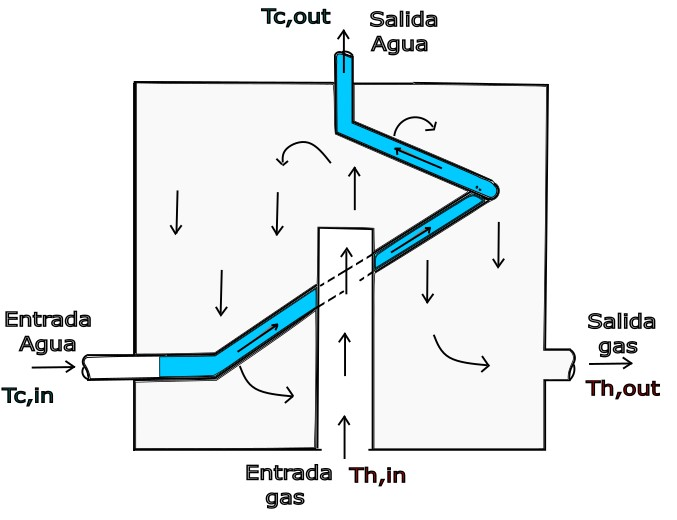

In [78]:
#Calculo LTMD intercmabiador contraflujo
delta_t_1 = T_ad - (Tw_out+273.15)
delta_t_2 = (Tg_out) - (Tw_in+273.15)
lmtd_cf = (delta_t_1-delta_t_2)/(mt.log(delta_t_1/delta_t_2)) #[K]

#Calculo LMTD a flujo cruzado
R_fc = (Tw_in-Tw_out)/(Tg_out-T_ad)
P_fc = (Tg_out-T_ad)/(Tw_in-T_ad)
F = 1 #valor asumido gráfica 11-18 Tc cengel
lmtd = F*lmtd_cf
print(f"\n \t diferencia media logaritmica flujo cruzado LMTD: {lmtd:.3f}[K]")

#ÁREA DEL INTERCAMBIADOR DE CALOR
A = (abs(Q_neto*1000))/(U*lmtd) #[m^2]
print(f"\n \t El área del intercambiador de calor es A: {A:.3f}[m^2]")

#longitud del intercambiador
L_inter = A/(mt.pi*(d_o-d_i))
print(f"\n \t La longitud del intercambiador es L: {L_inter:.3f}[m]")



 	 diferencia media logaritmica flujo cruzado LMTD: 288.850[K]

 	 El área del intercambiador de calor es A: 0.118[m^2]

 	 La longitud del intercambiador es L: 0.492[m]


# CALCULO LONGITUD DE TUBERÍA HIDRAULICA

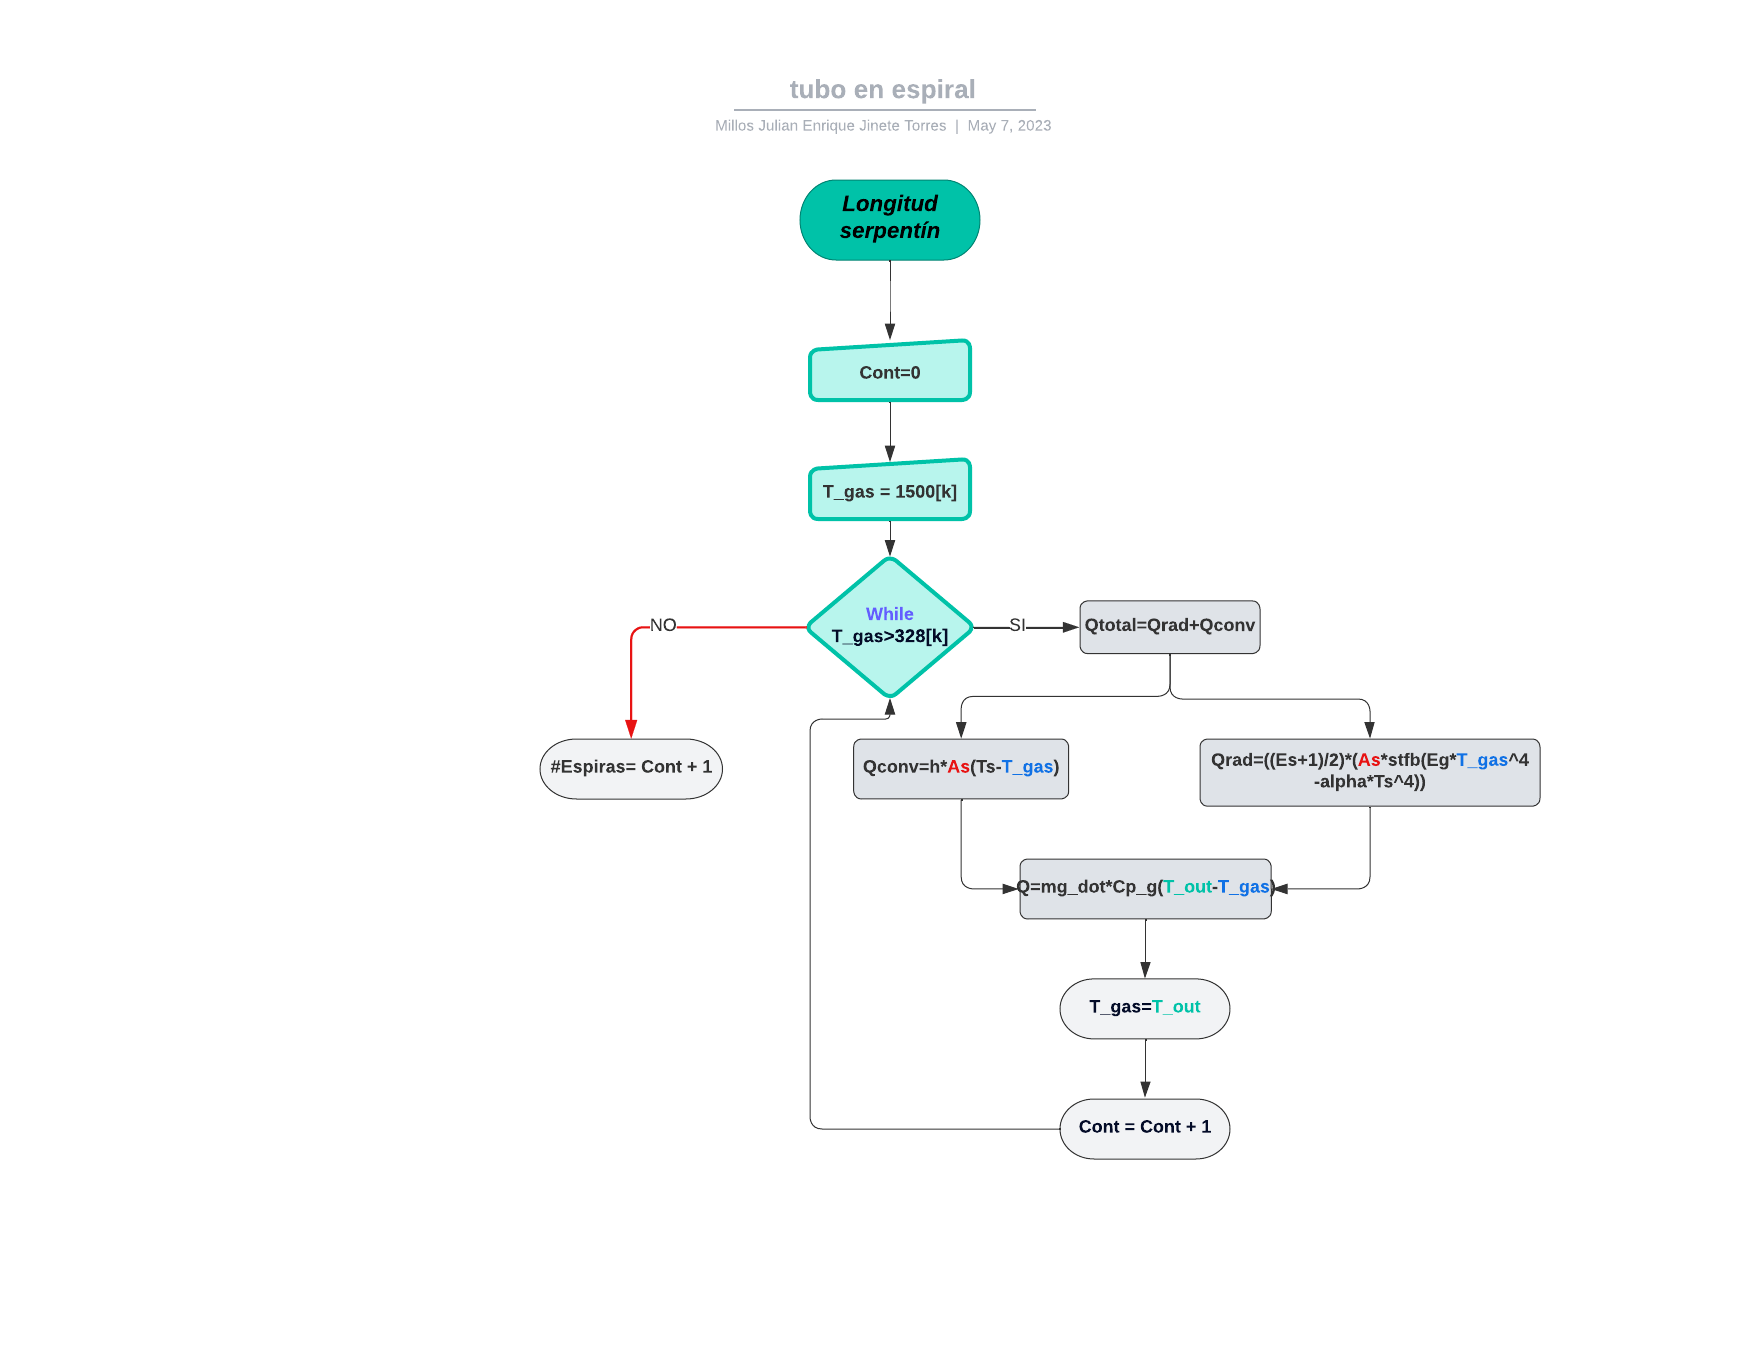

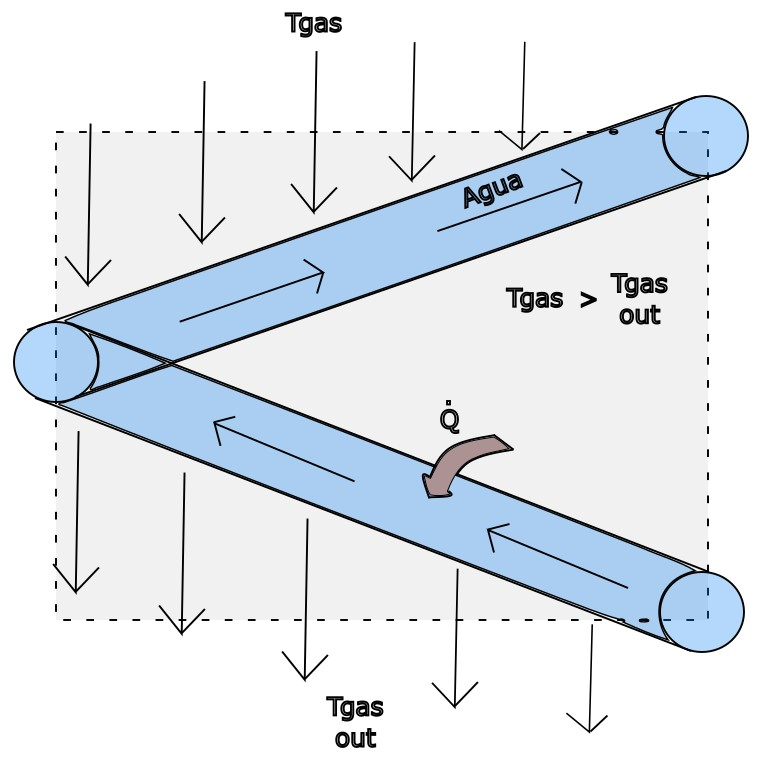

In [79]:
#flujo volumetrico = 60L/h
#calculo calor de convección
e_s = 0.8 #emisividad de superficie
m_dot_gas =0.7089 #flujo másico de gas total prod [Kg/h]
h_t = 7.267 #coef.tc convectivo [W/m^2*K]
A_s = 0.014 #área superficial de 1 espira [m^2]
e_c_a = 0.018 #gráfica 13-36 @1500K Pc*L*(Ts/Tg)
e_w_a = 0.028 #gráfica 13-36 @1500K Pc*L*(Ts/Tg)
e_c = 0.025 #gráfica 13-36 @1500K Pc*L=0.025
e_w = 0.016 #gráfica 13-36 @1500K Pw*L=0.045
rad = 0.0571 #[m] #radio de la espira vista frontal
perimetro_tubo = 2*mt.pi*rad  #perimetro de cada espira [m]

cont = 0
Tlist = []
X_axis = []

while T_gas>350:
    Tlist.append(T_gas)
    delta_tt = Tw_sup - T_gas #[K]
    Q_conv = h_t*A_s*delta_tt #calor convectivo [W]
    h_t-=0.5

#calculo calor de radiación
    e_gas = C_c*e_c + C_w*e_w
    
    alpha_c=C_c*(T_gas/Tw_sup)**0.65*(e_c_a)
    alpha_w=C_w*(T_gas/Tw_sup)**0.45*e_w_a
    

    alpha_g =alpha_c+alpha_w
    Q_rad = ((e_s+1)/2)*A_s*stfb*(e_gas*T_gas**4-alpha_g*Tw_sup**4) #[W]

    Q_total = Q_rad + Q_conv #[W]

    Cp_CO2 = CP.PropsSI('CPMASS', 'T', T_gas, 'P', 101325, 'CO2')/1000 #[Kj/Kg*K]
    Cp_H2O = CP.PropsSI('CPMASS', 'T', T_gas, 'P', 101325, 'H2O')/1000 #[Kj/Kg*K]
    Cp_N2 = CP.PropsSI('CPMASS', 'T', T_gas, 'P', 101325, 'N2')/1000 #[Kj/Kg*K]
    Cp_gas =Cp_CO2*gn_p["CO2"] +Cp_H2O*gn_p["H2O"]+Cp_N2*gn_p["N2"] #[Kj/Kg*K]
    
    #sumo esa cant aproximada debido a que los valores de emisividad y absortividad
    #aumentan segun disminuye la temperatura de los gases
    e_c_a +=0.005
    e_w_a +=0.005
    e_c+=0.005
    e_w+=0.005
    
    #calcula la temperatura de salida de los gases
    T_gas_out = T_gas-((Q_total*3600)/(m_dot_gas*Cp_gas*1000)) #[K]
    
    #igualo la temperatura de salida de los gases a la T_gas para que tome esa temperatura de salida
    #de los gases como la nueva temperatura de entrada de nuevo al ciclo y siga evaluando 
    #hasta q se cumpla la condición que me saque del ciclo 
    T_gas = T_gas_out
    ##
    cont +=1
    print(f"{T_gas:.3f}[K] -:{cont}") 
    
L_tubo = (cont)*perimetro_tubo #sumo una espiras extra [m]
print(f"\n \t La cantidad de espiras del intercambiador son:{cont} ")

print(f"\n \t La longitud del tubo es aproximadamente:{L_tubo:.3f} metros")


1356.386[K] -:1
1229.739[K] -:2
1127.966[K] -:3
1041.713[K] -:4
966.628[K] -:5
899.884[K] -:6
839.579[K] -:7
784.399[K] -:8
733.421[K] -:9
686.003[K] -:10
641.713[K] -:11
600.286[K] -:12
561.592[K] -:13
525.617[K] -:14
492.435[K] -:15
462.185[K] -:16
435.034[K] -:17
411.143[K] -:18
390.619[K] -:19
373.476[K] -:20
359.616[K] -:21
351.320[K] -:22
344.319[K] -:23

 	 La cantidad de espiras del intercambiador son:23 

 	 La longitud del tubo es aproximadamente:8.252 metros


	 Área del Intercambiador:0.118[m^2]
 	 Longitud Intercambiador(Sección anular):0.492[m]
     	 Longitud tubería agua: 8.252[m]
 	 Número de espiras: 24


Text(0.5, 0, '#Espiras')

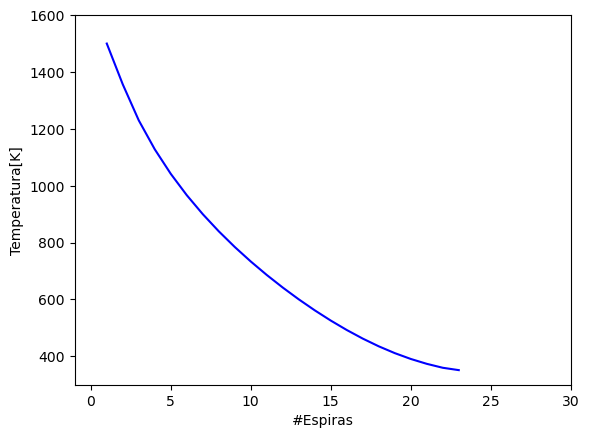

In [80]:
showSize()
for i in range(1,len(Tlist)+1):
    X_axis.append(i)

mp.plot(X_axis,Tlist,'blue')
mp.axis([-1,30,300,1600])
mp.ylabel("Temperatura[K]")
mp.xlabel("#Espiras")

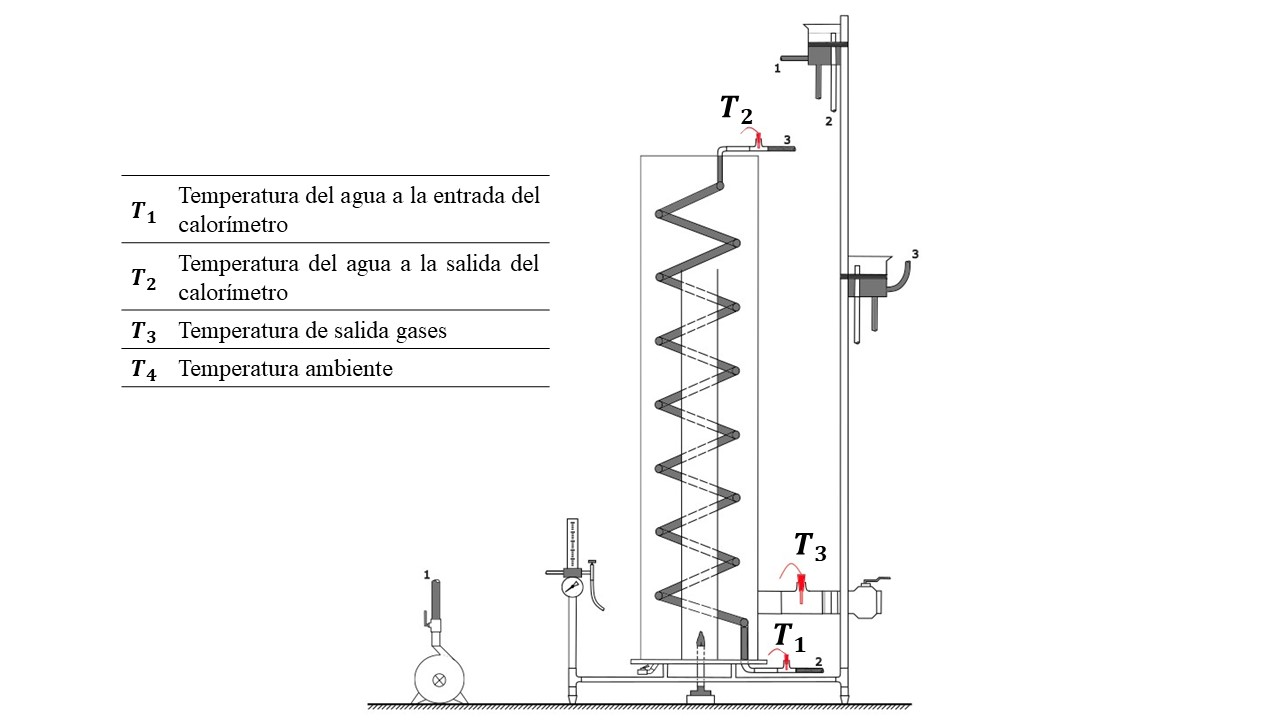

In [81]:
fHHV(1.5,1,25.5,30.5)

(48080.41056001223, 3.470851212352507)